# Quick Start
Hereâ€™s a basic example of how to use **pyramid-learn**, or **midlearn**, to explain a trained LightGBM model, utilizing the familiar scikit-learn API.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn import set_config

import lightgbm as lgb
import midlearn as mid 

# Set up plotnine theme for clean visualizations
import plotnine as p9
p9.theme_set(p9.theme_bw())

# Configure scikit-learn display
set_config(display='text')

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


## 1. Train a Black-Box Model
We use the California Housing dataset to train a LightGBM Regressor, which will serve as our black-box model.

In [2]:
# Load and prepare data
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit a LightGBM regression model
estimator = lgb.LGBMRegressor(random_state=42)
estimator.fit(X_train, y_train)

print(estimator)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.070349
LGBMRegressor(random_state=42)


## 2. Create an Explaination Model
We fit the `MIDExplainer` to the training data to create a globally faithful, interpretable surrogate model (MID).

In [3]:
# Initialize and fit the MID model
explainer = mid.MIDExplainer(
    estimator=estimator,
    interaction=True,
    params_main=70,
    penalty=.01,
    singular_ok=True,
)
explainer.fit(X_train)

print(explainer)

Generating predictions from the estimator...
MIDExplainer(estimator=LGBMRegressor(random_state=42), params_main=70,
             penalty=0.01)


In [4]:
# Check the fidelity of the surrogate model to the original model
print("R-squared score:", explainer.fidelity_score(X_test))

# Visualize the fidelity
p = p9.ggplot() \
    + p9.geom_abline(slope=1, color='gray') \
    + p9.geom_point(p9.aes(estimator.predict(X_test), explainer.predict(X_test)), alpha=0.5) \
    + p9.labs(
        x='Prediction (LightGBM Regressor)',
        y='Prediction (Surrogate MID Regressor)',
        title='Surrogate Model Fidelity Check'
    )
p

Generating predictions from the estimator...
R-squared score: 0.955195534503637


## 3. Visualize the Explanation Model
The MID model allows for clear visualization of feature importance, individual effects, and local prediction breakdowns.

In [5]:
# Calculate and plot overall feature importance (default bar plot and heatmap)
imp = explainer.importance()
display(imp.plot(theme='highlight'))
display(imp.plot(style='heatmap', color='#808080'))

--- Top 3 Main Effects ---
Plotting 1: Latitude


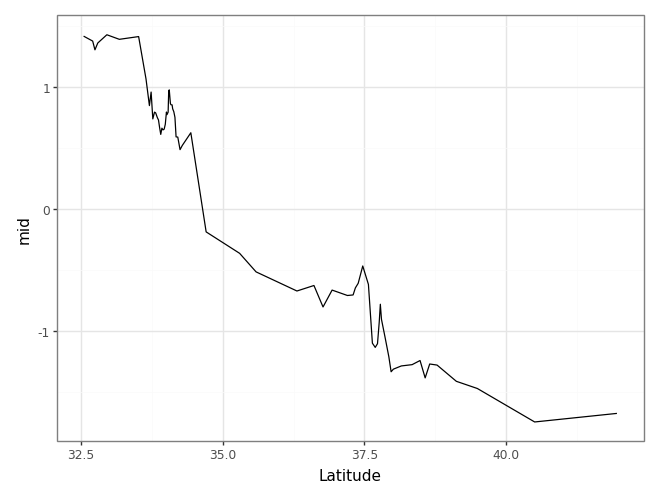

Plotting 2: Longitude


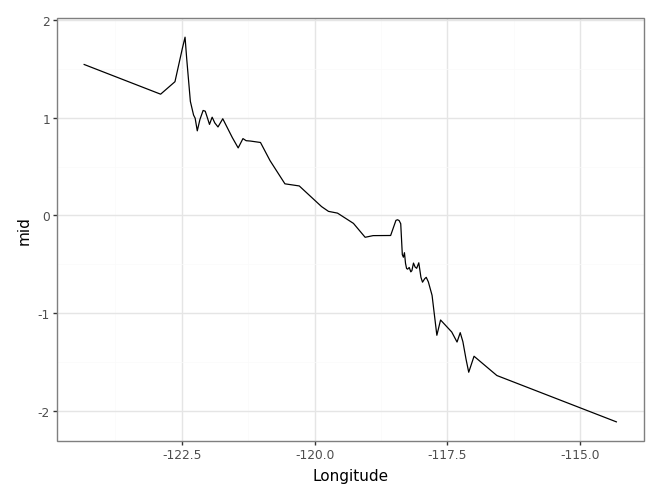

Plotting 3: MedInc


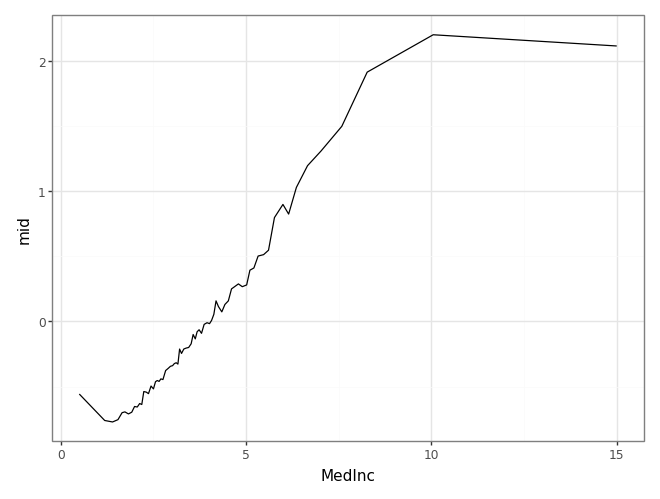

In [6]:
# Plot the top 3 important main effects (Component Functions)
print("--- Top 3 Main Effects ---")
for i, t in enumerate(imp.terms(interactions=False)[:3]):
    print(f"Plotting {i + 1}: {t}")
    p = explainer.plot(term=t)
    display(p)

In [7]:
# Plot the interaction of Longitude and Latitude (Component Functions)
display(
    explainer.plot("Longitude:Latitude", main_effects=True)
)
display(
    explainer.plot("Longitude:Latitude", style='data', data=X_train, main_effects=True)
)

--- Breakdown Plots for First 3 Test Samples ---
Row 0 Breakdown:


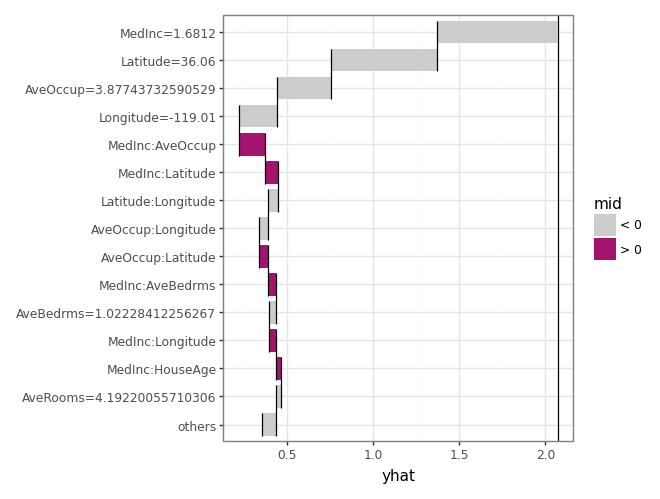

Row 1 Breakdown:


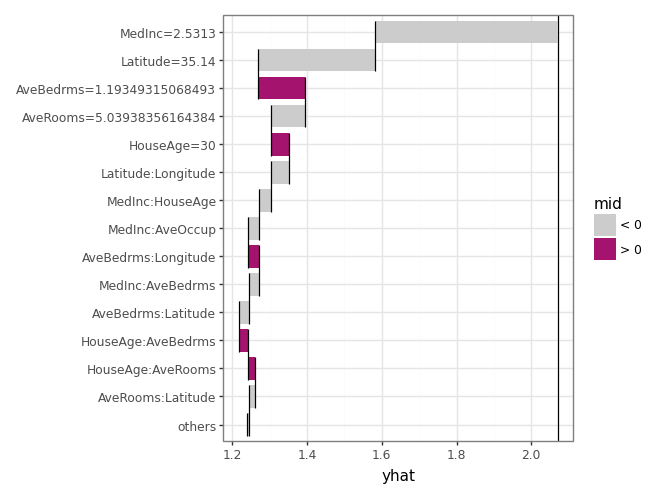

Row 2 Breakdown:


In [8]:
# Plot prediction breakdowns for the first three test samples (Local Interpretability)
print("--- Breakdown Plots for First 3 Test Samples ---")
for i in range(3):
    print(f"Row {i} Breakdown:")
    p = explainer.breakdown(row=i, data=X_test).plot(theme="highlight_r")
    display(p)

R callback write-console: the number of evaluation points exceeds the limit: the data is reduced to 1000 observations
  


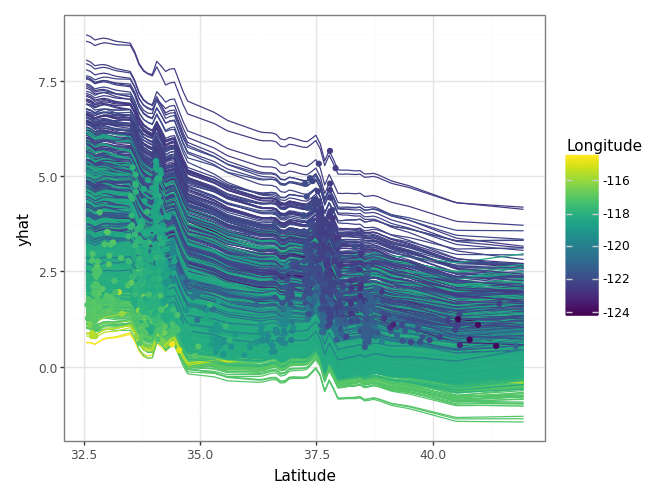

In [9]:
# Plot individual conditional expectations (ICE) with color encoding
explainer.conditional('Latitude').plot(var_color='Longitude')